<h1>Import modules</h1>

In [88]:
import math ; pi=math.pi
import numpy as np
# For plots
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [89]:
# Import PySSC module
import pyssc

<h1>I Compute a Sij matrix : turbo mode</h1>
<h3>Sharp / top-hat redshift bins</h3>

<h4>Define boundaries (stakes) of the redshift bins</h4>

In [90]:
#zstakes = np.linspace(0.1,1.5,num=15)
zstakes = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]) #Explicitely
zmin = np.min(zstakes) ; zmax = np.max(zstakes)

<h4>Compute the matrix</h4>

In [91]:
Sij = pyssc.turboSij(zstakes=zstakes)  #Uses the default cosmology of the article (arXiv:1809.05437) : Planck 2013 LCDM
#The computation takes ~15 seconds on an i7 laptop

In [92]:
# If you want to change cosmology, specify the parameters with a dictionnary in the format of CLASS :
params = {'omega_b':0.022,'omega_cdm':0.12,'H0':67.,'n_s':0.96,'sigma8':0.81}
Sijbis = pyssc.turboSij(zstakes=zstakes,cosmo_params=params)

<h1>Applications</h1>

<h3>Example 1: Plot the Sij matrix</h3>

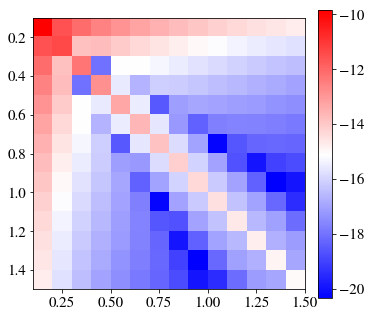

In [93]:
# Sij can be negative (anti-correlation between bins), and varies by seral order of magnitude due to redshift evolution.
# Let's first plot ln|Sij|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sij)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()

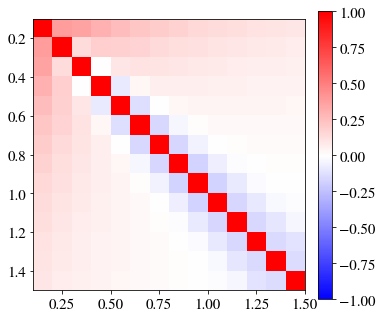

In [94]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
nzbins = len(zstakes) - 1
correl = np.zeros((nzbins,nzbins))
for i in range(nzbins):
    for j in range(nzbins):
        correl[i,j] = Sij[i,j] / np.sqrt(Sij[i,i]*Sij[j,j])
#Plot it
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correl,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()

<h3>Example 2: Find the characteristic multipole ell_SSC depending on redshift</h3>

In [95]:
# The multipole where the SSC decreases the S/N by a factor 2 compared to the Gaussian cosmic variance-limited case
# Defined in Eq.46 of the article (arXiv:1809.05437)
#Compute it
fsky    = 1.
Nprobes = 1.
Resp    = 5.
ell_SSC = np.zeros(nzbins)
for i in range(nzbins):
    ell_SSC[i] = np.sqrt(2./(Nprobes*Resp**2*fsky*Sij[i,i]))

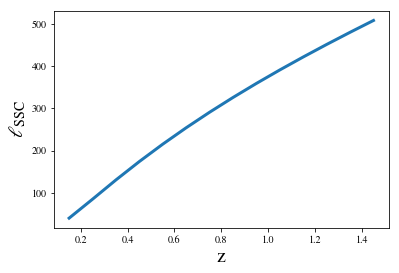

In [96]:
# Plot it as a function of redshift
zcenter = (zstakes[1:]+zstakes[:-1])/2.
plt.plot(zcenter,ell_SSC,lw=3)
plt.xlabel('z',fontsize=20) ; plt.ylabel(r'$\ell_\mathrm{SSC}$',fontsize=20)
plt.show()

<h4>so SSC starts to dominate for multipoles above a few hundred, i.e. sub-degree scale in real space</h4>

<h3>Example 3: Find the critical density of clusters where SSC/sample variance surpasses shot-noise/Poisson</h3>

In [97]:
# If Ncl is the cluster count (per steradian), then the shot-noise/Poisson variance is Cov_shot(Ncl)=Ncl/4pi
# and the SSC/sample variance is Cov_SSC = b^2 Ncl^2 * Sij
# the latter dominates shot-noise when Ncl >= Ncrit = 1./(4pi*b^2*Sij)

#Compute Ncrit
bcl = 5.                                  # Average cluster bias
Ncrit = np.zeros(nzbins)                  # Number density per sterad
for i in range(nzbins):
    Ncrit[i] = 1./(4.*pi*bcl**2*Sij[i,i])
Ncrit_deg2 = Ncrit * (pi/180.)**2         # Number density per deg^2

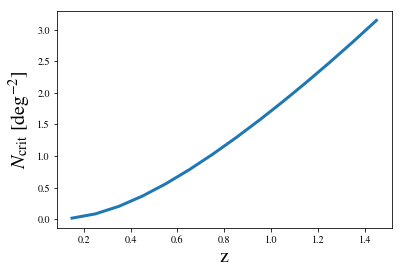

In [98]:
# Plot it as a function of redshift
plt.plot(zcenter,Ncrit_deg2,lw=3)
plt.xlabel('z',fontsize=20) ; plt.ylabel(r'$N_\mathrm{crit}$ [deg$^{-2}$]',fontsize=20)
#plt.savefig("Ncrit-halos-vs-z.png",bbox_inches='tight')
plt.show()

<h4>so SSC dominates when we detect more than a few clusters per square degree</h4>

<h1>II Compute a Sij matrix : general mode</h1>
<h3>With window functions</h3>

In [99]:
reload(pyssc)

<module 'pyssc' from 'pyssc.pyc'>

<h4>Define the window functions</h4>

In [100]:
# Define redshift range
nz       = 100
z_arr    = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0

In [101]:
# First top-hat window functions, for comparison with previous Sij case
#zstakes = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]) #already defined
nbins_T   = len(zstakes)-1
windows_T = np.zeros((nbins_T,nz))
for i in range(nbins_T):
    zminbin = zstakes[i] ; zmaxbin = zstakes[i+1] ; Dz = zmaxbin-zminbin
    for iz in range(nz):
        z = z_arr[iz]
        if ((z>=zminbin) and (z<=zmaxbin)):
            windows_T[i,iz] = 1/Dz
# Now Gaussian window functions
sigmaz    = 0.05
zcenters  = [0.4,0.8,1.2,1.6]
nbins_G   = len(zcenters)
windows_G = np.zeros((nbins_G,nz))
for i in range(nbins_G):
    windows_G[i,:] = np.exp(-(z_arr-zcenters[i])**2/(2*sigmaz**2)) / np.sqrt(2*pi*sigmaz**2)

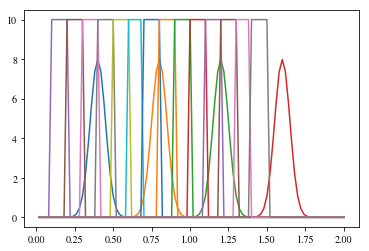

In [102]:
# Plot window functions
for i in range(nbins_G):
    plt.plot(z_arr,windows_G[i,:])
for i in range(nbins_T):   
    plt.plot(z_arr,windows_T[i,:])
plt.show()

<h4>Compute the matrix</h4>

In [103]:
Sijw_T = pyssc.Sij(z_arr,windows_T)
Sijw_G = pyssc.Sij(z_arr,windows_G)

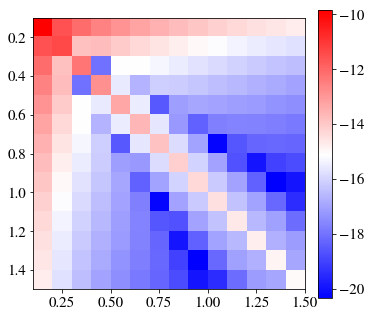

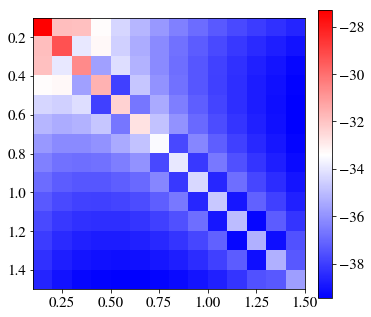

In [104]:
# Let's first plot ln|Sij|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sij)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
#
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sijw_T)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()